Learn source node representation u i ∈ R d and target node representation v i ∈ R d for each node i in
the graph. Given two nodes i and j, the representation learned should give P (A i,j = 1) = 1+exp 1 −u T v j .
i
Evaluate the link prediction performance on the test datasets and report the F1-score. For training,
this model assumes all the true edges have label 1, and you can use random negative sampling by
corrupting either the source or the target node to create a false edge and label them as -1.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
from torchvision import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [40]:
from google.colab import drive

drive.mount('/content/gdrive' ,force_remount=True)

Mounted at /content/gdrive


importing the cora dataset.
the problem is made more challenging by not giving the feature values of the nodes

In [41]:
true_train_edges=pd.read_csv("/content/gdrive/My Drive/datasets/lab_as2/train_edges.csv",header=None)
true_test_edges=pd.read_csv("/content/gdrive/My Drive/datasets/lab_as2/test_true_edges.csv")
false_test_edges=pd.read_csv("/content/gdrive/My Drive/datasets/lab_as2/false_data_test.csv",header=None)
labels_d=pd.read_csv("/content/gdrive/My Drive/datasets/lab_as2/labels.csv")
no_of_vertices=2277
true_train_edges

,0,1
0,617,292
1,1345,2013
2,1520,1579
3,1977,1132
4,42,540
...,...,...
4166,593,525
4167,220,491
4168,176,465
4169,2243,1522


In [42]:
false_test_edges

,0,1
0,1561,0
1,1353,2274
2,1240,1334
3,1853,1889
4,956,1077
...,...,...
1038,977,2275
1039,1131,442
1040,307,765
1041,67,1362


In [43]:
true_test_edges

,1561,582
0,1353,1123
1,1240,1240
2,1853,1719
3,956,950
4,2100,2204
...,...,...
1037,977,1122
1038,1131,773
1039,307,1860
1040,67,1873


preparing the adjacency matrix of the graph

In [44]:
adj=torch.zeros((no_of_vertices+1,no_of_vertices+1))
adj.shape

torch.Size([2278, 2278])

In [0]:
train_edge=torch.tensor(true_train_edges.values)
for i in range (len(train_edge)):
    adj[train_edge[i][0]][train_edge[i][1]]=1
    adj[train_edge[i][1]][train_edge[i][0]]=1

In [46]:
adj[617][292]

tensor(1.)

In [0]:
wrong_v=np.random.randint(0,no_of_vertices+1,len(train_edge))

negative sampling of the edges

In [0]:
train_edge_append=train_edge.clone()
for i in range(len(train_edge)):
    if adj[train_edge[i][0]][wrong_v[i]]==0:
        t=torch.tensor([[train_edge[i][0],wrong_v[i]]])
        train_edge_append=torch.cat((train_edge_append,t))
        

In [49]:
train_edge_append.size()

torch.Size([8332, 2])

In [50]:
train_edge.size()

torch.Size([4171, 2])

binary labeling

In [51]:
train_label=[]
for i in range(len(train_edge)):
    train_label.append(1)
for i in range(len(train_edge),len(train_edge_append)):
    train_label.append(-1)
train_label=torch.tensor(train_label)
train_label.size()

torch.Size([8332])

the embeder for the nodes with mse loss function

In [0]:
class Node(nn.Module):
    def __init__(self):
        super(Node, self).__init__()
        self.conv1 = nn.Conv1d(1,64,kernel_size=5, dilation=1, stride=1, padding=2,bias=True)
        self.fc1   = nn.Linear(145792,256)
        self.fc2=nn.Linear(256,32)
        
       
        self.components = {
            'bb': self.conv1,
            'fc': self.fc1,
            
        }
        
    def forward(self, input):

        out = F.relu(self.conv1(input))
        #print(out.size())
        B,H,W = out.size()
        out = out.view(B,-1) 
        out = self.fc1(out) 
        out=self.fc2(out)
       
        return out

In [53]:
x = torch.rand(64,1,no_of_vertices+1)
model2 = Node()
out = model2(x.float())
print(out)

tensor([[-0.1064,  0.0790,  0.1071,  ...,  0.0269, -0.0855,  0.2026],
        [-0.1224,  0.1457,  0.1504,  ..., -0.0086, -0.1132,  0.1827],
        [-0.0873,  0.0880,  0.1291,  ..., -0.0505, -0.0581,  0.1398],
        ...,
        [-0.0639,  0.1968,  0.1265,  ..., -0.0746, -0.0967,  0.1115],
        [-0.1554,  0.0697,  0.1297,  ...,  0.0342, -0.1319,  0.0965],
        [-0.0299,  0.0889,  0.1169,  ..., -0.0210, -0.0740,  0.1535]],
       grad_fn=<AddmmBackward>)


In [54]:
epoch = 5000
batch_size=64
model_embed = Node().cuda()
optimizer = torch.optim.Adam(model_embed.parameters(),
                                         lr=0.00001
                                        
                                         )
            
            
#optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
for e in range(epoch):
    batch1=np.random.randint(0,math.floor(len(train_edge_append))/2,32)
    batch2=np.random.randint(math.floor(len(train_edge_append)/2),len(train_edge_append),32)
    batch1=list(batch1)
    batch2=list(batch2)
    

    batch_start=adj[train_edge_append[batch1+batch2][:,0]]
    batch_end=adj[train_edge_append[batch1+batch2][:,1]]
  

    batch_label=train_label[batch1+batch2]
    batch_label=batch_label.cuda()
    x=torch.tensor(batch_start).unsqueeze(1)
    
    y=torch.tensor(batch_end).unsqueeze(1)
   # print(batch_label)
    x=x.cuda()
    y=y.cuda()
    x1=model_embed(x)
    y1=model_embed(y)

    pred=torch.bmm(x1.view(batch_size, 1,32), y1.view(batch_size, 32, 1)) 
    pred=pred.squeeze().squeeze().cuda()
    #print(pred)
    prob1=F.sigmoid(pred)
    prob2=(1-prob1)
    
    #print(prob1)
    p =  -torch.log(prob1)
    q= -torch.log(prob2)
    #print(p)
    #print(loss_matrix)
    total_loss = 0
    
    for i in range(batch_size):
        
#         print(batch_label[i],p[i])
        #total_loss += (1-batch_label[i])*q[i]+(p[i])*(batch_label[i])
#         if(batch_label[i]==0):
#             total_loss=q[i]
#         else:
#             total_loss=p[i]
        total_loss+=(batch_label[i]-prob1[i])**2

    loss = total_loss
    
    print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
#     print(y.size())
    if epoch % 100 ==0 :
      print('Epoch : '+str(e) + ' Loss : ---------------------------------------'+str(loss))
    if loss <.0001:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Streaming output truncated to the last 5000 lines.
Epoch : 17500 Loss : ---------------------------------------tensor(32.8327, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.0627, device='cuda:0', grad_fn=<AddBackward0>)
Epoch : 17501 Loss : ---------------------------------------tensor(32.0627, device='cuda:0', grad_fn=<AddBackward0>)
tensor(38.0555, device='cuda:0', grad_fn=<AddBackward0>)
Epoch : 17502 Loss : ---------------------------------------tensor(38.0555, device='cuda:0', grad_fn=<AddBackward0>)
tensor(37.4084, device='cuda:0', grad_fn=<AddBackward0>)
Epoch : 17503 Loss : ---------------------------------------tensor(37.4084, device='cuda:0', grad_fn=<AddBackward0>)
tensor(45.4611, device='cuda:0', grad_fn=<AddBackward0>)
Epoch : 17504 Loss : ---------------------------------------tensor(45.4611, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.6362, device='cuda:0', grad_fn=<AddBackward0>)
Epoch : 17505 Loss : ---------------------------------------tensor(32.6362, dev

plotting to see how it looks in the new space

In [59]:
label_d=labels_d.values[:,0]
new_space=[]
for i in range (len(label_d)):

  rep=adj[label_d[i]]
  rep=rep.cuda()
  new_space.append(model_embed(rep.unsqueeze(0).unsqueeze(0)).cpu().detach().numpy()[0])


from sklearn.manifold import TSNE


new_s=TSNE(n_components=2,verbose=1).fit_transform(new_space)
# new_space


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2210 samples in 0.005s...
[t-SNE] Computed neighbors for 2210 samples in 0.322s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2210
[t-SNE] Computed conditional probabilities for sample 2000 / 2210
[t-SNE] Computed conditional probabilities for sample 2210 / 2210
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.987366
[t-SNE] KL divergence after 1000 iterations: 1.548261


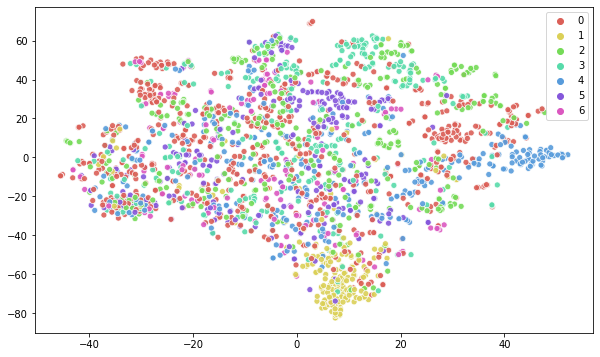

In [60]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(
    x=new_s[:,0], y=new_s[:,1],
    hue=labels_d.values[:,1],
    palette=sns.color_palette("hls", 7),
    legend="full",
    alpha=0.9
)

In [61]:
#true_test_edges #false_test_edges
test_edge=true_test_edges.values
res=[]
count=0
for i in range(len(test_edge)):
    rep1=adj[test_edge[i][0]]
    rep2=adj[test_edge[i][1]]
  
    rep1=rep1.cuda()
    rep2=rep2.cuda()
    model_start=model_embed(rep1.unsqueeze(0).unsqueeze(0))
    model_stop=model_embed(rep2.unsqueeze(0).unsqueeze(0))
    prod=torch.dot(model_start.squeeze(),model_stop.squeeze())
    pred=F.sigmoid(prod)
    if pred>.5:
      res.append(1)
      count+=1
    else:
      res.append(-1)
count/len(test_edge)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.8541266794625719

In [62]:
count=0
test_edge=false_test_edges.values
for i in range(len(test_edge)):
    rep1=adj[test_edge[i][0]]
    rep2=adj[test_edge[i][1]]
    rep1=rep1.cuda()
    rep2=rep2.cuda()
    
    model_start=model_embed(rep1.unsqueeze(0).unsqueeze(0))
    model_stop=model_embed(rep2.unsqueeze(0).unsqueeze(0))
    prod=torch.dot(model_start.squeeze(),model_stop.squeeze())
    pred=F.sigmoid(prod)
    if pred>.5:
      res.append(1)
      
    else:
      count+=1
      res.append(-1)
count/len(test_edge)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.48705656759348037

In [63]:
from sklearn.metrics import f1_score
tr=[1 for i in range(len(true_test_edges))]
for i in range(len(false_test_edges)):
  tr.append(-1)
print(f1_score(tr,res))

0.7215241183623835


**QUESTION 2 :**


Use the learned embedding u i ’s and train a supervised classifier on top it. Evaluate its performance on
different levels of supervision by varying percentage of labels used for supervision from 20% to 80% at
steps of 20. Report the Micro/Macro F1-score

In [0]:
class Seven_class(nn.Module):
    def __init__(self):
        super(Seven_class, self).__init__()
        
        self.fc1   = nn.Linear(32,7)
        
        
       
        self.components = {
            
            'fc': self.fc1
            
        }
        
    def forward(self, input):

        out = self.fc1(input)

        return out

In [32]:
x = torch.rand(1,32)
model3 = Seven_class()
out = model3(x.float())
print(out)

tensor([[ 0.1823,  0.0392,  0.0782, -0.5394,  0.1263, -0.3009,  0.2142]],
       grad_fn=<AddmmBackward>)


In [65]:
labels=pd.read_csv("/content/gdrive/My Drive/datasets/lab_as2/labels.csv",header=None)

labels=labels.values
labels

array([[   0,    0],
       [   2,    1],
       [   3,    1],
       ...,
       [2274,    4],
       [2275,    5],
       [2276,    0]])

In [0]:
sup=.8
train_label=labels[:int(len(labels)*sup)]
test_label=labels[int(len(labels)*sup):]

In [124]:
epoch = 5000
batch_size=64
model_classifier = Seven_class().cuda()
optimizer = torch.optim.Adam(model_classifier.parameters(),
                                         lr=0.001,
                                        
                                         )
            
            
#optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
for e in range(epoch):
    batch=np.random.randint(0,math.floor(len(train_label)),64)
    
    

   


    x=torch.tensor(adj[train_label[batch][:,0]]).unsqueeze(1)
    y=torch.tensor(train_label[batch][:,1])
   # print(batch_label)
    x=x.cuda()
    y=y.cuda()
    # print(x.size())
    x1=model_embed(x)
    # print(x1.size())
    x2=model_classifier(x1)
    

    
 
    
 
    # print(x2.size())
    x3 = F.softmax(x2, dim=-1)
    loss_matrix = - torch.log(x3)
    total_loss = 0
    for i in range(batch_size):
        total_loss += loss_matrix[i, y[i]]
    loss = total_loss / batch_size
    
    # print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
#     print(y.size())
    print('Epoch : '+str(e) + ' Loss : ---------------------------------------'+str(loss))
    if loss <.0001:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch : 0 Loss : ---------------------------------------tensor(2.1462, device='cuda:0', grad_fn=<DivBackward0>)
Epoch : 1 Loss : ---------------------------------------tensor(2.1436, device='cuda:0', grad_fn=<DivBackward0>)
Epoch : 2 Loss : ---------------------------------------tensor(2.1446, device='cuda:0', grad_fn=<DivBackward0>)
Epoch : 3 Loss : ---------------------------------------tensor(1.9441, device='cuda:0', grad_fn=<DivBackward0>)
Epoch : 4 Loss : ---------------------------------------tensor(2.2920, device='cuda:0', grad_fn=<DivBackward0>)
Epoch : 5 Loss : ---------------------------------------tensor(2.1335, device='cuda:0', grad_fn=<DivBackward0>)
Epoch : 6 Loss : ---------------------------------------tensor(2.0452, device='cuda:0', grad_fn=<DivBackward0>)
Epoch : 7 Loss : ---------------------------------------tensor(1.7707, device='cuda:0', grad_fn=<DivBackward0>)
Epoch : 8 Loss : ---------------------------------------tensor(1.9289, device='cuda:0', grad_fn=<DivBack

In [125]:
sample=test_label[:,0]
label=test_label[:,1]
count=0
k=-1

final_label=[]
for i in sample :
  k+=1
  x=model_embed(adj[i].unsqueeze(0).unsqueeze(0).cuda())
  x1=model_classifier(x)
  values=F.softmax(x1, dim=-1)
  #print("original"+str(label[k])+"  predict"+str(values.argmax()))
  final_label.append(values.argmax().cpu().detach().numpy())
  if label[k]==values.argmax():
    count+=1
count,len(sample)

print(f1_score(label,final_label,average='micro'))
print(f1_score(label,final_label,average='macro'))


0.45146726862302483
0.3886483431239368


**question 3**


Suggest an improvement to the representation learning model in (1) to incorporate the label information
into it so that semi-supervised learning is possible. Then find the classification and link prediction
performance for different levels of supervision by varying percentage of labels used for supervision from
20% to 80% at steps of 20. Compare the performances in two settings and write your inferences on the
performance gap.

In [0]:
class Node_for_link(nn.Module):
    def __init__(self):
        super(Node_for_link, self).__init__()
        self.conv1 = nn.Conv1d(1,64,kernel_size=5, dilation=1, stride=1, padding=2,bias=True)
        self.fc1   = nn.Linear(145792,256)
        self.fc2=nn.Linear(256,7)
        
       
        self.components = {
            'bb': self.conv1,
            'fc': self.fc1,
            
        }
        
    def forward(self, input):

        out = F.relu(self.conv1(input))
        #print(out.size())
        B,H,W = out.size()
        out = out.view(B,-1) 
        out = self.fc1(out) 
        out=self.fc2(out)
       
        return out

In [0]:
model_embed_class = Node_for_link().cuda()

In [128]:
epoch = 2000
batch_size=64
model_embed_class = Node_for_link().cuda()
optimizer = torch.optim.Adam(model_embed_class.parameters(),
                                         lr=0.00001,
                                        
                                         )
            
            
#optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
for e in range(epoch):
    batch=np.random.randint(0,math.floor(len(train_label)),64)
    
    

   


    x=torch.tensor(adj[train_label[batch,0]]).unsqueeze(1)
    y=torch.tensor(train_label[batch][:,1])
   # print(batch_label)
    x=x.cuda()
    y=y.cuda()
    # print(x.size())
   # x1=model_embed(x)
    # print(x1.size())
    x2=model_embed_class(x)
    

    
 
    
 
    # print(x2.size())
    x3 = F.softmax(x2, dim=-1)
    loss_matrix = - torch.log(x3)
    total_loss = 0
    for i in range(batch_size):
        total_loss += loss_matrix[i, y[i]]
    loss = total_loss / batch_size
    
    # print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
#     print(y.size())
    print('Epoch : '+str(e) + ' Loss : ---------------------------------------'+str(loss))
    if loss <.0001:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch : 0 Loss : ---------------------------------------tensor(1.9502, device='cuda:0', grad_fn=<DivBackward0>)
Epoch : 1 Loss : ---------------------------------------tensor(1.9163, device='cuda:0', grad_fn=<DivBackward0>)
Epoch : 2 Loss : ---------------------------------------tensor(1.7378, device='cuda:0', grad_fn=<DivBackward0>)
Epoch : 3 Loss : ---------------------------------------tensor(2.0356, device='cuda:0', grad_fn=<DivBackward0>)
Epoch : 4 Loss : ---------------------------------------tensor(2.0542, device='cuda:0', grad_fn=<DivBackward0>)
Epoch : 5 Loss : ---------------------------------------tensor(1.8284, device='cuda:0', grad_fn=<DivBackward0>)
Epoch : 6 Loss : ---------------------------------------tensor(1.8067, device='cuda:0', grad_fn=<DivBackward0>)
Epoch : 7 Loss : ---------------------------------------tensor(1.9188, device='cuda:0', grad_fn=<DivBackward0>)
Epoch : 8 Loss : ---------------------------------------tensor(1.9010, device='cuda:0', grad_fn=<DivBack

In [129]:
sample=test_label[:,0]
label=test_label[:,1]
pred_label=[]
count=0
k=-1
for i in sample :
  k+=1
  x=model_embed_class(adj[i].unsqueeze(0).unsqueeze(0).cuda())

  values=F.softmax(x, dim=-1)
  # values[0][3]=0
  #print("original"+str(label[k])+"  predict"+str(values.argmax()))
  pred_label.append(values.argmax().cpu().detach())
 
  if label[k]==values.argmax():
    # print(label[k],values.argmax())
    count+=1
    
# print(label)
# print(pred_label)
# pred_label=pred_label.cpu().detach().numpy()
print(f1_score(label,pred_label,average='micro'))
print(f1_score(label,pred_label,average='macro'))

0.6568848758465011
0.6369045505432377


In [130]:
#true_test_edges #false_test_edges
test_edge=true_test_edges.values
res=[]
count=0
for i in range(len(test_edge)):
    rep1=adj[test_edge[i][0]]
    rep2=adj[test_edge[i][1]]
  
    rep1=rep1.cuda()
    rep2=rep2.cuda()
    model_start=model_embed_class(rep1.unsqueeze(0).unsqueeze(0))
    model_stop=model_embed_class(rep2.unsqueeze(0).unsqueeze(0))
   
    pred1=F.softmax(model_start,dim=-1)
    pred2=F.softmax(model_stop,dim=-1)
    pred1_m=torch.argmax(pred1)
    pred2_m=torch.argmax(pred2)
    # print(pred1_m,pred2_m)
    if pred1_m==pred2_m :
      res.append(1)
      
      count+=1
    else:
      res.append(-1)
count/len(test_edge)

0.736084452975048

In [131]:
count=0
test_edge=false_test_edges.values
for i in range(len(test_edge)):
    rep1=adj[test_edge[i][0]]
    rep2=adj[test_edge[i][1]]
  
    rep1=rep1.cuda()
    rep2=rep2.cuda()
    model_start=model_embed_class(rep1.unsqueeze(0).unsqueeze(0))
    model_stop=model_embed_class(rep2.unsqueeze(0).unsqueeze(0))
   
    pred1=F.softmax(model_start,dim=-1)
    pred2=F.softmax(model_stop,dim=-1)
    pred1_m=torch.argmax(pred1)
    pred2_m=torch.argmax(pred2)
    if pred1_m==pred2_m:
      # print(pred1_m,pred2_m)
      res.append(1)
      
    else:
      count+=1
      res.append(-1)
count/len(test_edge)

0.7564717162032598

In [132]:
from sklearn.metrics import f1_score
tr=[1 for i in range(len(true_test_edges))]
for i in range(len(false_test_edges)):
  tr.append(-1)
print(f1_score(tr,res))

0.7435773145904022
